In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


In [59]:
class Model(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.GELU(),
            nn.Linear(100, z_dim),
            nn.GELU()
        )

        self.decode = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.GELU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [64]:
model = Model(5)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

n_epochs = 5
losses = []
for epoch in range(1, n_epochs+1):
    print('EPOCH', epoch)
    batch_losses = []
    for x, _ in tqdm(trainloader):
        x_hat = model(x)
        
        loss = loss_fn(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
    print('Loss', losses[-1])
    

EPOCH 1


100%|██████████| 938/938 [00:11<00:00, 80.51it/s]


Loss 0.059764508308886466
EPOCH 2


100%|██████████| 938/938 [00:11<00:00, 78.98it/s]


Loss 0.04833752637319982
EPOCH 3


100%|██████████| 938/938 [00:13<00:00, 70.94it/s]


Loss 0.04512093328177802
EPOCH 4


100%|██████████| 938/938 [00:14<00:00, 64.07it/s]


Loss 0.042085270740901994
EPOCH 5


100%|██████████| 938/938 [00:15<00:00, 59.70it/s]

Loss 0.039619813150942707


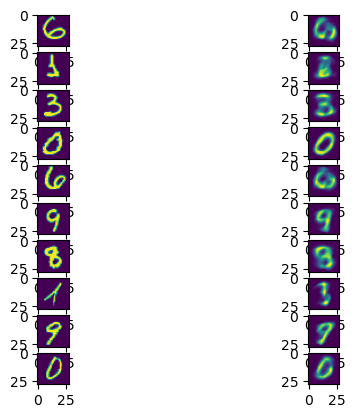

In [65]:
for x, _ in valloader:
    fig, ax = plt.subplots(10, 2)
    x_hat = model(x).detach().numpy()

    for n in range(10):
        ax[n][0].imshow(x[n][0])
        
        
        
        ax[n][1].imshow(x_hat[n][0])
    
    break

In [62]:
z = torch.randn(1, 10)

plt.imshow(model.decode(z).detach().numpy()[0][0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 5x100)